### Table of contents
What is LangGraph

Overview

Key components

How langgraph works

Experimenting with LangGraph

Pre-requisites

Installing dependencies

Setting up the environment variables

1. Tool Calling in LangGraph

2. Using pre-built agent

3. Building a custom agent

Applications of LangGraph


#### What is LangGraph
Before LangGraph, the agent executor class in LangChain was the primary tool for building AI agents. It operated by using an agent in a loop to make decisions, execute actions, and log observations. However, this class had limited flexibility, constraining developers to a fixed pattern of tool calling and error handling, making it difficult to build dynamic and adaptable agent runtimes.

LangGraph is an advanced library within the LangChain ecosystem addresses these limitations by introducing cyclic computational capabilities. While LangChain supports Directed Acyclic Graphs (DAGs) for linear workflows, LangGraph enables the creation of cycles, allowing LLM agents to dynamically loop through processes and make decisions based on evolving conditions. This framework empowers developers to build more complex, flexible, and adaptive agent systems.

Overview
LangGraph is a library built on top of LangChain, designed to create cyclic graphs for LLM-based AI agents.
It enables cyclic graph topologies for workflows, allowing more flexible and nuanced agent behaviors than linear models.
Utilizes key elements:
— Nodes: Represent functions or LangChain runnable items.
— Edges: Define execution and data flow.
— Stateful graphs: Manage persistent data across execution cycles.
Supports multi-agent coordination, allowing each agent to have its own prompt, LLM, tools and custom code within a single graph.
Introduces a chat agent executor that represents agent state as a list of messages, ideal for chat-based models.

#### Key Components
State maintains and updates the context or memory as the process advances and enabling each step to access relevant information from earlier steps for dynamic decision-making.

Nodes represent individual computation steps or tasks, performing specific functions like data processing, decision-making or system interactions.

Edges connect nodes, dictating the flow of computation and allowing conditional logic to guide the workflow based on the current state, supporting complex and multi-step operations.

Stateful graph is central to its architecture, where each node represents a step in the computation. The graph maintains and updates a shared state as the process advances.

#### How LangGraph works
LangGraph enables cyclic LLM call execution with state persistence, essential for agentic behavior. LangGraph Inspired by Pregel and Apache Beam and modeled after the NetworkX library for user-friendly graph-based programming offers a more advanced approach to agent runtimes. Unlike its predecessors, which rely on basic loops, LangGraph supports intricate systems of nodes and edges, allowing developers to create more complex decision-making processes and action sequences.

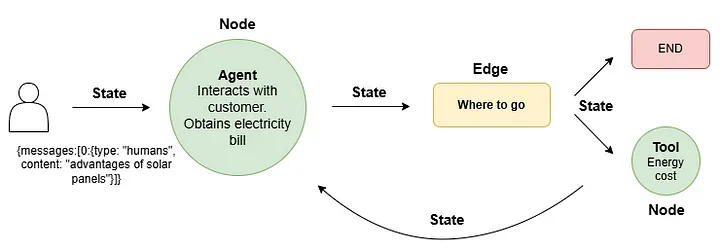


The diagram illustrates how LangGraph facilitates a dynamic, cyclic workflow for AI agents. The process begins with an initial state, which contains input data or context (in this case, a message from the customer asking about the advantages of solar panels). This state is passed to an agent node, which interacts with the customer to gather information, such as obtaining their electricity bill. After this interaction, the state is updated with the gathered information and passed to an edge, which represents a decision point. At this point, the system evaluates the state and decides where to proceed next, depending on the updated information. This could lead to a tool interaction or move directly towards an end state.

If the decision is to engage with a tool, another node is triggered, where the tool (in this case, an energy cost calculator) processes the data. This step involves a function that executes specific operations, again updating the state as the workflow continues. Finally, the system can either reach an end state, concluding the process, or cycle back, repeating the steps with the updated state if further actions are required. This feedback loop allows for ongoing, dynamic decision-making based on evolving conditions, showcasing how LangGraph’s cyclic graphs enable flexible and iterative agent behaviors.

### Use Case : Weather in real time using ai agent using langgraph framework

#### 1. Tool Calling in LangGraph

In [17]:
# Import the keys
import os
from dotenv import load_dotenv
load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']


# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")


In [18]:
# Import the required libraries and methods
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

#### Defining tools
We will create two tools:

1. For fetching weather data for weather-related queries.

2. For internet searches when the LLM lacks the answer.

In [19]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

#### calling llm

In [20]:
openai_api_version

'2024-05-01-preview'

In [23]:
# If you have OpenAI key
# llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-U7tijaa4jwHvhVWGr....", temperature=0)


## if you have azure openai

from langchain_openai import AzureChatOpenAI

model=  "gpt-4o-mini"


if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=model,
    openai_api_version=openai_api_version,
)

tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

In [24]:
prompt = """
    Given only the tools at your disposal, mention tool calls for the following tasks:
    Do not change the query given for any search tasks
        1. What is the current weather in Trivandrum today
        2. Can you tell me about Kerala
        3. Why is the sky blue?
    """

results = llm_with_tools.invoke(prompt)

print(results.tool_calls)

query = "What is the current weather in Trivandrum today"
response = llm.invoke(query)
print(response.content)

[{'name': 'get_weather', 'args': {'query': 'current weather in Trivandrum today'}, 'id': 'call_qnhfi6LJwSOp3aQ4AloWJJvr', 'type': 'tool_call'}, {'name': 'search_web', 'args': {'query': 'Can you tell me about Kerala'}, 'id': 'call_C5pItsNOj20hgd8YRwgAsinS', 'type': 'tool_call'}, {'name': 'search_web', 'args': {'query': 'Why is the sky blue?'}, 'id': 'call_nzr2KpWPF9oBBz14V9wHz1CF', 'type': 'tool_call'}]
I'm unable to provide real-time weather updates. To find the current weather in Trivandrum, I recommend checking a reliable weather website or using a weather app for the latest information.


##### I'm unable to provide real-time weather updates. To find the current weather in Trivandrum, I recommend checking a reliable weather website or using a weather app for the latest information.

### 2. Using pre-built agent
LangGraph offers a pre-built React(Reason and Act) agent, designed to streamline decision-making and action execution.

Let’s explore how it works.

In [26]:
from langgraph.prebuilt import create_react_agent

# system prompt is used to inform the tools available to when to use each
system_prompt = """Act as a helpful assistant.
    Use the tools at your disposal to perform tasks as needed.
        - get_weather: whenever user asks get the weather of a place.
        - search_web: whenever user asks for information on current events or if you don't know the answer.
    Use the tools only if you don't know the answer.
    """

# we can initialize the agent using the llama3 model, tools, and system prompt.
agent = create_react_agent(model=llm, tools=tools, state_modifier=system_prompt)

# Let’s query the agent to see the result.
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "What is the current weather in Jaipur today")]}

print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current weather in Jaipur today
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_0NWuvqCIAaqQlXlT8WsS9zuh)
 Call ID: call_0NWuvqCIAaqQlXlT8WsS9zuh
  Args:
    query: Jaipur
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Jaipur", "region": "Rajasthan", "country": "India", "lat": 26.9167, "lon": 75.8167, "tz_id": "Asia/Kolkata", "localtime_epoch": 1736146241, "localtime": "2025-01-06 12:20"}, "current": {"last_updated_epoch": 1736145900, "last_updated": "2025-01-06 12:15", "temp_c": 23.7, "temp_f": 74.6, "is_day": 1, "condition": {"text": "Sunny", "icon": "//cdn.weatherapi.com/weather/64x64/day/113.png", "code": 1000}, "wind_mph": 7.2, "wind_kph": 11.5, "wind_degree": 331, "wind_dir": "NNW", "pressure_mb": 1014.0, "pressure_in": 29.95, "precip_mm": 0.0, "pre

#### Note : 
The output demonstrates how the LLM leverages external tools to answer user queries. The LLM invoked the search_web tool and get_weather API to retrieve relevant information. The search_web tool successfully fetched a URL and extracted content, which the LLM then used to generate a response to the query. Similarly, the LLM utilized the get_weather API to fetch current weather information and incorporated it into its output for providing an accurate answer.

### 3. Building a custom agent
Now, let’s create an agent using LangGraph.

In [30]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

##### Define a tool_node with the available tools. The ToolNode is a LangChain Runnable that takes graph state, which includes a list of messages as input and produces an updated state as the results of the tool calls.

In [ ]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

In [31]:
tools = [search_web, get_weather]
tool_node = ToolNode(tools)

tool_node

tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'search_web': StructuredTool(name='search_web', description='Search the web for a query', args_schema=<class 'langchain_core.utils.pydantic.search_web'>, func=<function search_web at 0x0000017A278CC9A0>), 'get_weather': StructuredTool(name='get_weather', description='Search weatherapi to get the current weather', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x0000017A2FF03920>)}, tool_to_state_args={'search_web': {}, 'get_weather': {}}, tool_to_store_arg={'search_web': None, 'get_weather': None}, handle_tool_errors=True, messages_key='messages')

##### Define functions to call the model or tools.

In [50]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print("----------------------------------call_model----------------------------------------")
    print(messages)
    print("----------------------------------call_model----------------------------------------")
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("----------------------------------call_tools----------------------------------------")
    print(messages)
    last_message = messages[-1]
    print(last_message)
    check_tool=last_message.tool_calls
    print("called tool info:", check_tool)
    print("----------------------------------call_tools----------------------------------------")
    
    if check_tool:
        return "tools"
    return END

##### Note : The call_model function takes messages from the state as input, which can include queries, prompts or tool content and returns a response. The call_tools function also accepts state messages as input and returns the tools node if the last message includes tool calls else it terminates.






#### Now, let’s create the nodes and edges.

In [51]:
# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

##### Note : 
The above code initializes a workflow using the StateGraph class with the MessagesState. It first adds a node named LLM that utilizes the call_model function to make decisions based on the provided input. The workflow begins with the LLM node and establishes a connection to a tools node, which is created using the tool_node. Conditional edges are then added, allowing the workflow to either proceed to the tools node or terminate based on the output of the LLM node, which leads back to the LLM for further processing

##### visualize the graph

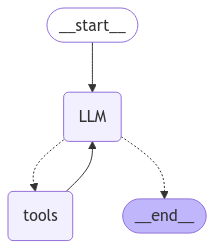

In [52]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### Now, let’s query the agent.


In [59]:
for chunk in agent.stream(
    {"messages": [("user", "Will it rain in Jaipur tommarrow?")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Will it rain in Jaipur tommarrow?
----------------------------------call_model----------------------------------------
[HumanMessage(content='Will it rain in Jaipur tommarrow?', additional_kwargs={}, response_metadata={}, id='1afa47d8-e143-4007-a045-4a3f4cce797a')]
----------------------------------call_model----------------------------------------
----------------------------------call_tools----------------------------------------
[HumanMessage(content='Will it rain in Jaipur tommarrow?', additional_kwargs={}, response_metadata={}, id='1afa47d8-e143-4007-a045-4a3f4cce797a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wKlOuA0c1ZZDnbwvSw4dqSv3', 'function': {'arguments': '{"query":"Jaipur"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 76, 'total_tokens': 91, 'completion_tokens_details

#### Note : i.e. it always calls model first

### Now, checking which tools it calls according to user input
#### Example _01

In [55]:
for chunk in agent.stream(
    {"messages": [("user", "hello, how are you?")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hello, how are you?
----------------------------------call_model----------------------------------------
[HumanMessage(content='hello, how are you?', additional_kwargs={}, response_metadata={}, id='85d6e5b2-d1b7-410b-8836-b99cb96b5683')]
----------------------------------call_model----------------------------------------
----------------------------------call_tools----------------------------------------
[HumanMessage(content='hello, how are you?', additional_kwargs={}, response_metadata={}, id='85d6e5b2-d1b7-410b-8836-b99cb96b5683'), AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 73, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasonin

##### Note : when it call calls_tools() functin it return empty "called tool info: []", i.e. no tool is called.

#### Example -02 :

In [56]:
for chunk in agent.stream(
    {"messages": [("user","current weather in jaipur")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

current weather in jaipur
----------------------------------call_model----------------------------------------
[HumanMessage(content='current weather in jaipur', additional_kwargs={}, response_metadata={}, id='312ad702-9b14-4e96-9a45-d72ace71904f')]
----------------------------------call_model----------------------------------------
----------------------------------call_tools----------------------------------------
[HumanMessage(content='current weather in jaipur', additional_kwargs={}, response_metadata={}, id='312ad702-9b14-4e96-9a45-d72ace71904f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hu82xCgSAjBNuFR1nmqcJArG', 'function': {'arguments': '{"query":"Jaipur"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 72, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction

##### Note : when it call calls_tools() functin it return "called tool info: [{'name': 'get_weather', 'args': {'query': 'Jaipur'}, 'id': 'call_Hu82xCgSAjBNuFR1nmqcJArG', 'type': 'tool_call'}]", i.e. get_weather() function tool was called. 